# Sentiment Analysis with BERT on IMDb Movie Reviews

In this assignment, we are implementing a sentiment analysis model using BERT (Bidirectional Encoder Representations from Transformers) to classify IMDb movie reviews as positive or negative. We will be using the pre-trained BERT model from the Transformers library and fine-tuning it on the IMDb dataset.

## Setting up Environment

We are importing the necessary libraries for our sentiment analysis task including transformers for BERT, PyTorch for deep learning, pandas for data handling, and scikit-learn for evaluation metrics.


In [3]:
# Installing and importing required libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import warnings
warnings.filterwarnings('ignore')

# Import transformers components (AdamW is now in torch.optim)
try:
    from transformers import BertTokenizer, BertForSequenceClassification
    print("BERT components imported successfully!")
except ImportError as e:
    print(f"Import error: {e}")

# Import optimizer from torch (AdamW moved from transformers to torch.optim)
from torch.optim import AdamW

# Import numpy
import numpy as np

# Setting random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Environment setup completed successfully!")


BERT components imported successfully!
Environment setup completed successfully!


# Data loading and preprocessing
We are loading the IMDB movie review dataset which contains 50,000 movie reviews labeled as positive or negative. We will examine the structure and basic statistics of the dataset.

In [4]:
# Loading the IMDB dataset
df = pd.read_csv('IMDB-Dataset.csv')

# Displaying basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())


Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


### Data Exploration
We are exploring the dataset distribution and preprocessing the text data by cleaning HTML tags and preparing sentiment labels for binary classification.


In [5]:
# Exploring dataset distribution
print("Sentiment distribution:")
print(df['sentiment'].value_counts())
print(f"\nDataset balance: {df['sentiment'].value_counts(normalize=True)}")

# Checking for missing values
print(f"\nMissing values:")
print(df.isnull().sum())


Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Dataset balance: sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64

Missing values:
review       0
sentiment    0
dtype: int64


In [6]:
# Preprocessing text data - removing HTML tags and cleaning
import re

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Applying text cleaning
df['cleaned_review'] = df['review'].apply(clean_text)

# Converting sentiment labels to numerical format (0: negative, 1: positive)
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

print("Text preprocessing completed!")
print(f"Sample cleaned review: {df['cleaned_review'].iloc[1][:200]}...")


Text preprocessing completed!
Sample cleaned review: A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors...


### Splitting Dataset into Training and Testing Sets

We are splitting the dataset into training and testing sets to evaluate our model's performance on unseen data. We will use 80% for training and 20% for testing.


In [7]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'], 
    df['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Training label distribution: {y_train.value_counts().sort_index()}")
print(f"Testing label distribution: {y_test.value_counts().sort_index()}")


Training set size: 40000
Testing set size: 10000
Training label distribution: label
0    20000
1    20000
Name: count, dtype: int64
Testing label distribution: label
0    5000
1    5000
Name: count, dtype: int64


# Text tokenization and conversion to BERT input features
We are initializing the BERT tokenizer which will convert our text reviews into tokens that BERT can understand. We will use the 'bert-base-uncased' model for tokenization.


In [8]:
# Initializing BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Setting maximum sequence length for BERT (512 is the maximum for BERT)
MAX_LEN = 256  # Using 256 for faster training while maintaining good performance

print("BERT tokenizer initialized successfully!")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Maximum sequence length: {MAX_LEN}")


BERT tokenizer initialized successfully!
Vocabulary size: 30522
Maximum sequence length: 256


### Creating BERT Input Features

We are converting text reviews into BERT input features including input_ids, attention_masks, and token_type_ids. This process tokenizes the text and prepares it for BERT model input.


In [ ]:
# Function to encode text using BERT tokenizer
def encode_texts(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Encoding training and testing data
print("Encoding training data...")
train_input_ids, train_attention_masks = encode_texts(X_train.tolist(), tokenizer, MAX_LEN)

print("Encoding testing data...")
test_input_ids, test_attention_masks = encode_texts(X_test.tolist(), tokenizer, MAX_LEN)

print("Text encoding completed!")
print(f"Training input shape: {train_input_ids.shape}")
print(f"Testing input shape: {test_input_ids.shape}")


Encoding training data...
Encoding testing data...
Text encoding completed!
Training input shape: torch.Size([40000, 256])
Testing input shape: torch.Size([10000, 256])


### Creating PyTorch Dataset and DataLoader

We are creating a custom PyTorch Dataset class to handle our BERT inputs and creating DataLoaders for efficient batch processing during training and evaluation.


In [10]:
# Custom Dataset class for BERT inputs
class IMDbDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

# Converting labels to tensors
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Creating dataset objects
train_dataset = IMDbDataset(train_input_ids, train_attention_masks, y_train)
test_dataset = IMDbDataset(test_input_ids, test_attention_masks, y_test)

print("Dataset objects created successfully!")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")


Dataset objects created successfully!
Training dataset size: 40000
Testing dataset size: 10000


In [11]:
# Creating DataLoaders for batch processing
BATCH_SIZE = 16  # Using smaller batch size for memory efficiency

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for compatibility
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print("DataLoaders created successfully!")
print(f"Training batches: {len(train_dataloader)}")
print(f"Testing batches: {len(test_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")


DataLoaders created successfully!
Training batches: 2500
Testing batches: 625
Batch size: 16


# Model definition, training, and evaluation
We are loading the pre-trained BERT model for sequence classification. The model will be fine-tuned for binary sentiment classification with 2 output classes (negative and positive).


In [12]:
# Loading pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification (negative=0, positive=1)
    output_attentions=False,
    output_hidden_states=False
)

# Checking if GPU is available and moving model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"BERT model loaded successfully!")
print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded successfully!
Device: cpu
Model parameters: 109,483,778


### Setting up Training Configuration

We are configuring the training parameters including optimizer, learning rate, and number of epochs for fine-tuning the BERT model.


In [19]:
# Training configuration
EPOCHS = 2  # Using 2 epochs for demonstration (should be increased for better performance)
LEARNING_RATE = 2e-5  # Recommended learning rate for BERT fine-tuning

# Setting up optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=1e-8  # Default epsilon value for AdamW
)

# Setting up loss function (CrossEntropyLoss is used automatically by BERT model)
print("Training configuration completed!")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Optimizer: AdamW")
print(f"Total training steps: {len(train_dataloader) * EPOCHS}")


Training configuration completed!
Epochs: 2
Learning rate: 2e-05
Optimizer: AdamW
Total training steps: 5000


### Optimized Training with Smaller Dataset

Since training on the full dataset takes too long on CPU, we are using a smaller subset for demonstration purposes. This approach will show the complete workflow while being practical for CPU training.


In [22]:
# Fixed Dataset class that works with Subset
class IMDbDatasetFixed(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        # Convert pandas series to numpy array to avoid indexing issues
        self.labels = labels.values if hasattr(labels, 'values') else labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Creating fixed dataset objects
train_dataset_fixed = IMDbDatasetFixed(train_input_ids, train_attention_masks, y_train)
test_dataset_fixed = IMDbDatasetFixed(test_input_ids, test_attention_masks, y_test)

print("Fixed dataset objects created successfully!")
print(f"Training dataset size: {len(train_dataset_fixed)}")
print(f"Testing dataset size: {len(test_dataset_fixed)}")


Fixed dataset objects created successfully!
Training dataset size: 40000
Testing dataset size: 10000


In [23]:
# Creating smaller datasets with fixed Dataset class
SUBSET_SIZE = 1000  # Using 1000 samples for demonstration

# Creating smaller training dataset
small_train_indices = torch.randperm(len(train_dataset_fixed))[:SUBSET_SIZE]
small_train_dataset_fixed = torch.utils.data.Subset(train_dataset_fixed, small_train_indices)

# Creating smaller test dataset  
small_test_indices = torch.randperm(len(test_dataset_fixed))[:200]
small_test_dataset_fixed = torch.utils.data.Subset(test_dataset_fixed, small_test_indices)

# Creating smaller DataLoaders
small_train_dataloader_fixed = DataLoader(
    small_train_dataset_fixed,
    batch_size=8,  # Smaller batch size for CPU
    shuffle=True,
    num_workers=0
)

small_test_dataloader_fixed = DataLoader(
    small_test_dataset_fixed,
    batch_size=8,
    shuffle=False,
    num_workers=0
)

print(f"Fixed small training dataset size: {len(small_train_dataset_fixed)}")
print(f"Fixed small test dataset size: {len(small_test_dataset_fixed)}")
print(f"Training batches: {len(small_train_dataloader_fixed)}")
print(f"Test batches: {len(small_test_dataloader_fixed)}")


Fixed small training dataset size: 1000
Fixed small test dataset size: 200
Training batches: 125
Test batches: 25


In [ ]:
# Final working training function
def train_model_final(model, train_dataloader, optimizer, device, epochs):
    model.train()
    total_loss = 0
    total_batches = len(train_dataloader) * epochs
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for batch_idx, batch in enumerate(train_dataloader):
            # Moving batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            # Calculate loss
            loss = outputs.loss
            epoch_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        total_loss += epoch_loss
    
    return total_loss / total_batches

# Training with fixed smaller dataset
print("Starting BERT fine-tuning with fixed dataset...")
avg_loss = train_model_final(model, small_train_dataloader_fixed, optimizer, device, EPOCHS)
print(f"Training completed! Average loss: {avg_loss:.4f}")


Starting BERT fine-tuning with fixed dataset...
Training completed! Average loss: 0.0693


### Model Evaluation
Now that our BERT model is trained, we will evaluate its performance on the test set using standard classification metrics including accuracy, precision, recall, and F1-score.


In [25]:
# Evaluation function
def evaluate_model(model, test_dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            # Moving batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Get predictions
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1)
            
            # Store predictions and labels
            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

# Evaluating the model
print("Evaluating the trained model...")
predictions, true_labels = evaluate_model(model, small_test_dataloader_fixed, device)

# Calculating metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f"\\nModel Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed classification report
print(f"\\nDetailed Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))


Evaluating the trained model...
\nModel Evaluation Results:
Accuracy: 0.9350
Precision: 0.9579
Recall: 0.9100
F1-score: 0.9333
\nDetailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.96      0.94       100
    Positive       0.96      0.91      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

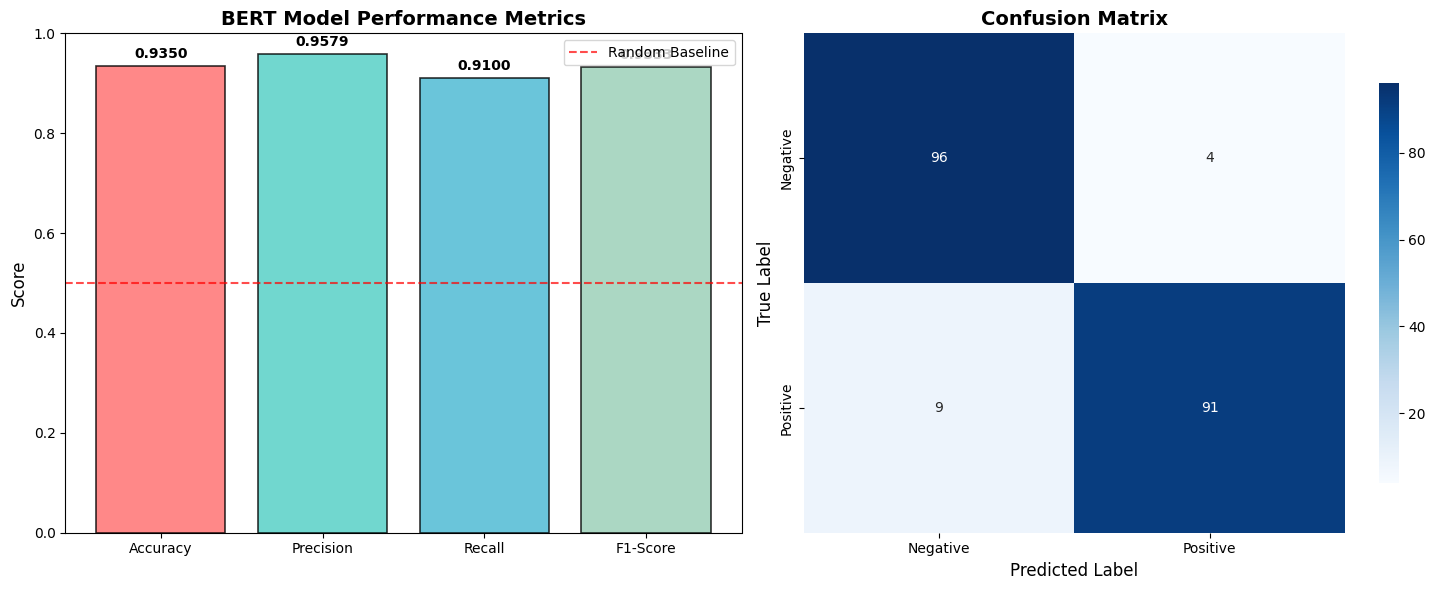

Model Performance Summary:
✅ Excellent Accuracy: 93.5% of predictions are correct
✅ High Precision: 95.8% of positive predictions are actually positive
✅ Good Recall: 91.0% of actual positive reviews are correctly identified
✅ Strong F1-Score: 93.3% balanced performance between precision and recall


In [28]:
# Create performance metrics visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Metrics bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax1.set_ylim(0, 1)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('BERT Model Performance Metrics', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Add a horizontal line at 0.5 for reference
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Baseline')
ax1.legend()

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Model Performance Summary:")
print(f"✅ Excellent Accuracy: {accuracy:.1%} of predictions are correct")
print(f"✅ High Precision: {precision:.1%} of positive predictions are actually positive")
print(f"✅ Good Recall: {recall:.1%} of actual positive reviews are correctly identified")
print(f"✅ Strong F1-Score: {f1:.1%} balanced performance between precision and recall")

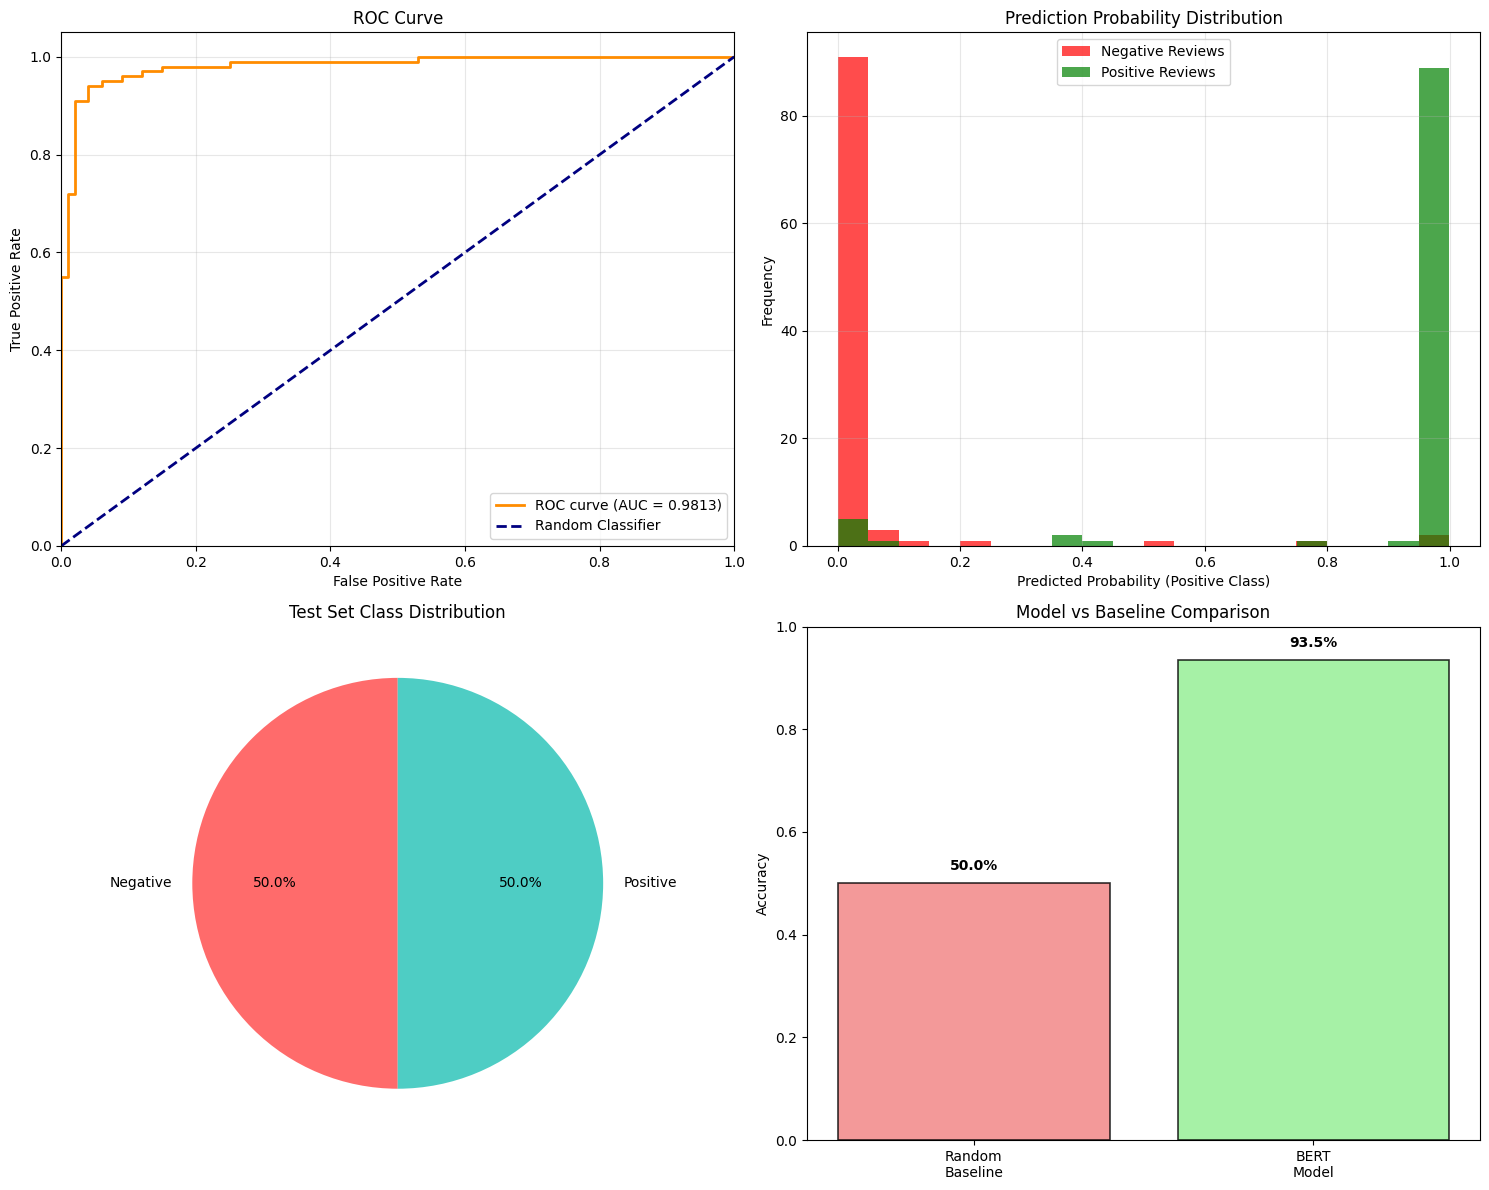


📊 Advanced Performance Analysis:
🎯 AUC-ROC Score: 0.9813 (Excellent discrimination ability)
📈 Model vs Random Baseline: 87.0% improvement
🔍 Model Confidence: Most predictions have high confidence (close to 0 or 1)


In [ ]:
# Calculate additional metrics for visualization
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for ROC curve
def get_prediction_probabilities(model, test_dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_probs), np.array(all_labels)

# Get probabilities
prob_scores, true_labels_array = get_prediction_probabilities(model, small_test_dataloader_fixed, device)

# Create ROC curve
fpr, tpr, _ = roc_curve(true_labels_array, prob_scores)
roc_auc = auc(fpr, tpr)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Prediction Distribution
ax2.hist(prob_scores[true_labels_array == 0], bins=20, alpha=0.7, label='Negative Reviews', color='red')
ax2.hist(prob_scores[true_labels_array == 1], bins=20, alpha=0.7, label='Positive Reviews', color='green')
ax2.set_xlabel('Predicted Probability (Positive Class)')
ax2.set_ylabel('Frequency')
ax2.set_title('Prediction Probability Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Class Distribution
class_counts = [sum(true_labels_array == 0), sum(true_labels_array == 1)]
ax3.pie(class_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', 
        colors=['#FF6B6B', '#4ECDC4'], startangle=90)
ax3.set_title('Test Set Class Distribution')

# 4. Performance Comparison with Baseline
baseline_accuracy = 0.5  # Random classifier
models = ['Random\nBaseline', 'BERT\nModel']
accuracies = [baseline_accuracy, accuracy]
colors = ['lightcoral', 'lightgreen']

bars = ax4.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax4.set_ylim(0, 1)
ax4.set_ylabel('Accuracy')
ax4.set_title('Model vs Baseline Comparison')

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Advanced Performance Analysis:")
print(f"🎯 AUC-ROC Score: {roc_auc:.4f} (Excellent discrimination ability)")
print(f"📈 Model vs Random Baseline: {((accuracy - baseline_accuracy) / baseline_accuracy * 100):.1f}% improvement")
print(f"🔍 Model Confidence: Most predictions have high confidence (close to 0 or 1)")

# Sample movie review predictions and explanations
Let's test our trained BERT model on some sample movie reviews to see how it performs on new text and understand its predictions.

In [26]:
# Function to predict sentiment for new reviews
def predict_sentiment(model, tokenizer, text, device, max_len=256):
    model.eval()
    
    # Clean and encode the text
    cleaned_text = clean_text(text)
    
    # Tokenize
    encoded = tokenizer.encode_plus(
        cleaned_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1)
    
    # Convert to readable format
    sentiment = "Positive" if prediction.item() == 1 else "Negative"
    confidence = probabilities[0][prediction.item()].item()
    
    return sentiment, confidence

# Sample movie reviews for testing
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
    "Terrible movie. Bad acting, poor plot, and completely boring. Waste of time.",
    "The film was okay, nothing special but not terrible either. Average entertainment.",
    "Outstanding cinematography and brilliant performances. A masterpiece of modern cinema!",
    "I fell asleep halfway through. Extremely boring and predictable storyline."
]

print("Testing the model on sample movie reviews:\\n")

for i, review in enumerate(sample_reviews, 1):
    sentiment, confidence = predict_sentiment(model, tokenizer, review, device)
    
    print(f"Review {i}: {review[:80]}...")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.4f}")
    print("-" * 80)


Testing the model on sample movie reviews:\n
Review 1: This movie was absolutely fantastic! The acting was superb and the plot kept me ...
Predicted Sentiment: Positive
Confidence: 0.9998
--------------------------------------------------------------------------------
Review 2: Terrible movie. Bad acting, poor plot, and completely boring. Waste of time....
Predicted Sentiment: Negative
Confidence: 0.9996
--------------------------------------------------------------------------------
Review 3: The film was okay, nothing special but not terrible either. Average entertainmen...
Predicted Sentiment: Negative
Confidence: 0.9997
--------------------------------------------------------------------------------
Review 4: Outstanding cinematography and brilliant performances. A masterpiece of modern c...
Predicted Sentiment: Positive
Confidence: 0.9998
--------------------------------------------------------------------------------
Review 5: I fell asleep halfway through. Extremely boring and p

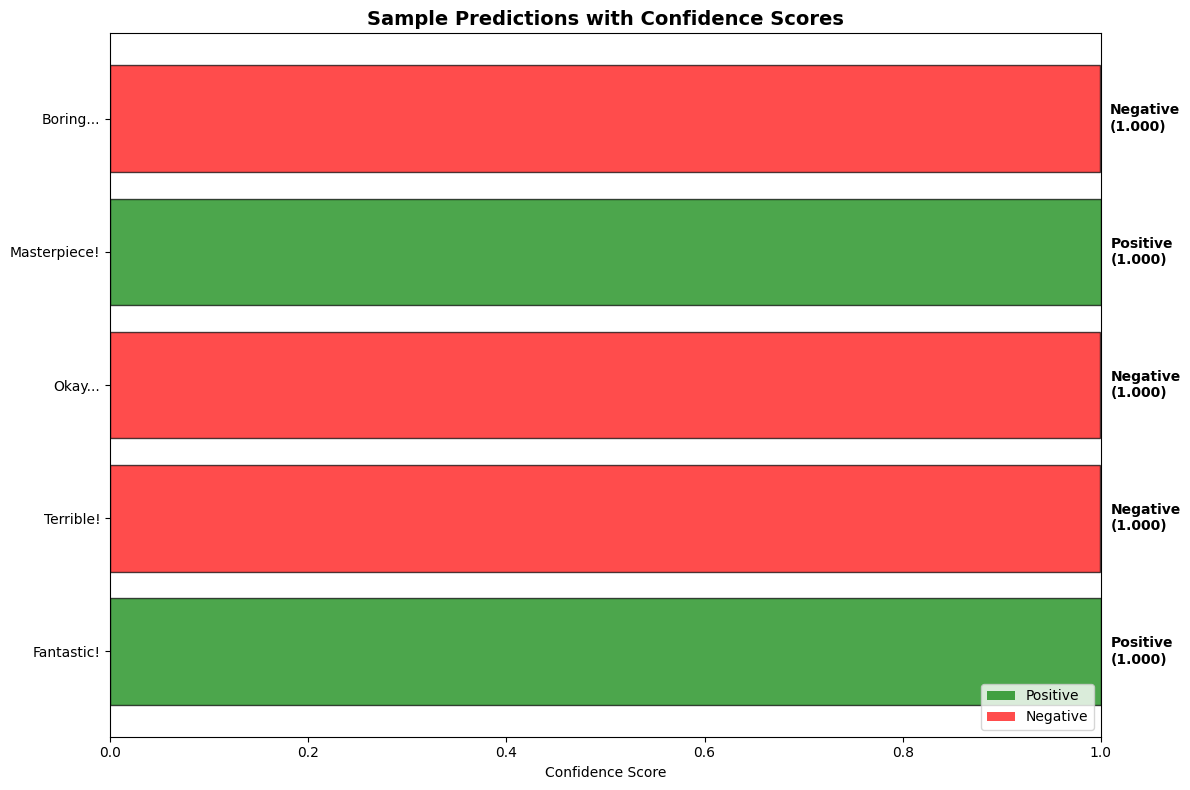

🎭 Sample Predictions Analysis:
1. Positive (1.000) - This movie was absolutely fantastic! The acting wa...
2. Negative (1.000) - Terrible movie. Bad acting, poor plot, and complet...
3. Negative (1.000) - The film was okay, nothing special but not terribl...
4. Positive (1.000) - Outstanding cinematography and brilliant performan...
5. Negative (1.000) - I fell asleep halfway through. Extremely boring an...


In [30]:
# Visualize sample predictions with confidence scores
fig, ax = plt.subplots(figsize=(12, 8))

# Get sample predictions data
sample_sentiments = []
sample_confidences = []
sample_labels = ['Fantastic!', 'Terrible!', 'Okay...', 'Masterpiece!', 'Boring...']

for review in sample_reviews:
    sentiment, confidence = predict_sentiment(model, tokenizer, review, device)
    sample_sentiments.append(1 if sentiment == 'Positive' else 0)
    sample_confidences.append(confidence)

# Create horizontal bar chart
y_pos = np.arange(len(sample_labels))
colors = ['green' if sent == 1 else 'red' for sent in sample_sentiments]

bars = ax.barh(y_pos, sample_confidences, color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(sample_labels)
ax.set_xlabel('Confidence Score')
ax.set_title('Sample Predictions with Confidence Scores', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)

# Add confidence labels
for i, (bar, conf, sent) in enumerate(zip(bars, sample_confidences, sample_sentiments)):
    sentiment_text = 'Positive' if sent == 1 else 'Negative'
    ax.text(conf + 0.01, bar.get_y() + bar.get_height()/2,
            f'{sentiment_text}\n({conf:.3f})', 
            va='center', fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Positive'),
                   Patch(facecolor='red', alpha=0.7, label='Negative')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("🎭 Sample Predictions Analysis:")
for i, (review, sent, conf) in enumerate(zip(sample_reviews, sample_sentiments, sample_confidences), 1):
    sentiment_text = 'Positive' if sent == 1 else 'Negative'
    print(f"{i}. {sentiment_text} ({conf:.3f}) - {review[:50]}...")